# Intro

<font size="3">This notebook uses an existing dataset with car models (found [here](https://ai.stanford.edu/~jkrause/cars/car_dataset.html)) to define a new dataset of car types. The new dataset is meant to be used for training YOLOv5s. This is achieved in two parts.

<font size="3">In the first part, we present an exploration of the existing car dataset. This contains 16,185 images of 196 models (classes) of cars. This dataset was last updated in 2013, and has a single class label for each image.

### <font size="2"> Dataset description:<font>

<font size="2"> No of classes        : 196   </br>
No of examples       :  16,185  </br>
Class description format    : Make, Model, Year  (e.g "Volkswagen Beetle Hatchback 2012)   </br>
Bounding Box format  :   [Xmin,Ymin, Xmax, Ymax] (pixel value) </br>
Train/test split           :  ~50-50 </br> <font>


<font>

</br>
    
<font size="3">In the second part, we use this dataset to define a new dataset with car types (new classes), to be used with Yolo V5s.<font>

### <font size="2"> Dataset description:<font>
<font size="2">
No of classes        : 9   </br>
No of examples       :  4482  </br>
Class description format    : Car-type (e.g. Hatchback)     </br>
Bounding Box format  : [Xc, Yc, w, h] (normalized)   </br>
train/valid split           : 80-20% <font>
</br>
</br>
</br>

<font size="2">
Note:
The original dataset was prepared in 2013. It was used for the work titled '3D Object Representations for Fine-Grained Categorizatio',by Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei, at the 4th IEEE Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.

    
<font>
    
</br>
</br>
</br>
</br>


# Contents:



## [Part A: Data exploration](#A)

- [1) Manual inspection - Dataset distribution.](#A-1)
- [2) Analysis of datasets.](#A-2)
- [3) Bounding box inspection.](#A-3)
- [4) Data modifications: Correcting identified errors](#A-4)

## [Part B: Preparing the new dataset](#B)


- [1) Define new classes](#B-1)
- [2) Re-separate examples and prepare the dataset for Yolo v5.](#B-2)


### Consistency checks:

- [Verify that all examples in the train/test datasets are incluted in the aggregated dataset (cars_annos).](#cons1)
- [Check for duplicate examples.](#cons2)


In [1]:
###
#Installing needed packages:
###

import scipy.io # for reading .mat files
import pandas as pd # for dataframes
import numpy as np #                               
import matplotlib.pyplot as plt # for graphs
import os # for OS interaction 
import sys
import cv2 #for image manipulation
import random # for randomly separating test/valid dataset
import shutil # for copying files in train/valid folders
import yaml # for preparing yaml file

In [2]:
###
#Reading the data:
###


cars_test_annos = scipy.io.loadmat('Data/cars_test_annos_withlabels.mat') # annotations for test images
cars_train = scipy.io.loadmat('Data/cars_train_annos.mat') # annotations for train images
cars_meta = scipy.io.loadmat('Data/cars_meta.mat') # classes description
cars_annos = scipy.io.loadmat('Data/cars_annos.mat') # all examples in one folder

In [3]:
###
# Options:
###

#to have the same "random" results.
SEED = 5 

# Option to prepare all train and test examples with their bounding box in a new folder for inspection ("Y"/"N").
# If yes, examples are saved in ..Data/train_bb/ and Data/test_bb/
SAVE_BB_IMG = "Y" 

# Option for the train/valid split percent:
train_prc = 80

# Option to prepare and write a new dataset with images (data/train/images data/test/images) with the new redefined class:
prepare_test_valid = True

# Option to prepare and write the labels in yolov5 format in txt files (data/train/labels data/test/labels)
write_txt_files = True

<a name='A'></a>
# Part A: Data Exploration

<a name='A-1'></a>
## 1) Manual inspection - Dataset distribution.
After manual inspection of all images, we identified some common characteristics of them. Images with similar characteristics as those in the training set, are expected to perform well on the final model.

- ### Characteristics of images: </br>

    - Images in both the test and train datasets have common characteristics, come from the same dataset distribution.
    - Most images are from car ads: 
        - some have exotic backrounds from proffesional photographers.
        - most show specific angles of a car.  
        - some have text from the ad or dealership on the picture.
    - There are no street view images.
    - All are from a similar prespective (eye level).
    - Almost all images show a complete car. No image shows par of the car.
    - Some have a white backround behind the car.
    - Some have multiple cars, but only one bounding box is marked and one class is labeled.
    - Some have multiple images of the same car, or parts of the car, but again only 1 bounding box is marked (as verified  [here](#1-3)).
    - Very few images (like train/08144.jpg or test/01569.jpg) are black and white. 
    - Car models are updated until year 2013.

- ### Image to correct:</br>
    - One image (in the train/07389.jpg, also in the cars_ims/002568.jpg) is rotated (the bounding box is referred to the non rotated image, as will be verified later ([here](#rotated)).
    
- ### Comments: </br>
    - Single-object bounding boxes in the original dataset will result in poor training for multi-object detection.
    - Data coming from street view images come from a different distribution. The prediction of such images is expected to be worse than from images that come from the same distribution.  
    - Car models included will bee outdated (2013 Vs 2022) compared to streed view images.
    - Not all car brands are included. This will incorporate some bias in the model towards the included car brands.
    
<a name='A-2'></a>
## 2) Analysis of the datasets
</br>

<a name='cons1'></a>
Before starting the analysis, we want to verify that all images that are included in the test / train datasets are also included in the downloaded complete dataset

In [31]:
###
# The check is based on the number of filenames provided in the .mat files for each dataset (cars_train / cars_test / cars_annos)
###

test_examples_count = len(cars_test_annos['annotations'][0])
train_examples_count = len(cars_train['annotations'][0])
examples_count = len(cars_annos['annotations'][0])

#Check to verify that all examples listed in the test and train are included in the cars_annos folder:
if test_examples_count+train_examples_count == examples_count:
    print ("All examples in test and train are included in the total")
else:
    print ("Not all examples in test and train are included in the total")

All examples in test and train are included in the total


### Analysis of number of images per dataset, per class

First we count the number of examples for each class.

In [5]:
###
#Create a dataframe with example counts for each class, for each dataset (train/test/total)
###

# Create a dataframe with number of class ('class_no') and the class description ('class_descr')
classes = [str(cars_meta['class_names'][0][i][0]) for i in range(0,len(cars_meta['class_names'][0]))]
classes_df = pd.DataFrame(classes)
classes_df.reset_index(inplace=True)
classes_df.columns = ['class_no','class_descr']
classes_df['class_no']=classes_df['class_no']+1



#Helper fucntion: create a df with the class number and example counts for each class
def examples_per_class (dataset):
    '''
    returns a df with the class for each image in the train/test/total dataset.
    Arguments:
        dataset -> (string) option for the analysis dataset, it can be either train or test
    Results:
        returns the dataframe
    '''
    item_no = 4 #the position of the array to which the class is located
    if dataset == 'train':
        annotations = cars_train['annotations'][0] #showing the place where we find the class annotations for the training set
        col_name = 'train_exmpl_count'
    elif dataset == 'test':
        annotations = cars_test_annos['annotations'][0]#showing the place where we find the class annotations for the test set
        col_name = 'test_exmpl_count'
    elif dataset == 'total':
        annotations = cars_annos['annotations'][0]#showing the place where we find the class annotations for the test set
        col_name = 'total_exmpl_count'
        item_no = 5
    annos = [[element[0][0] for element in upperElement] for upperElement in annotations] #list of annotations per example
    class_list = [int(element[item_no]) for element in annos] # list of classes per example
    class_per_image = pd.DataFrame(class_list) # datafrane with the class for each example
    df2 = class_per_image.iloc[:, 0].value_counts().sort_index(ascending=True).to_frame() # dataframe with counts of examples per class
    df2.reset_index(inplace=True)
    df2 = df2.rename(columns = {'index':'class_no'})
    df2 = df2.rename(columns = {0:col_name})
    return df2


# Create dataframes with the class and count for each dataset
for dataset in ['test', 'train', 'total']:
    locals()[dataset+"_classes_df"] = examples_per_class(dataset)
    #Dataframes will be named: test_df, train_df and total_df accordingly
    

# Merge the data frames together 
classes_df = pd.merge(classes_df, train_classes_df, on = "class_no", how = "inner")
classes_df = pd.merge(classes_df, test_classes_df, on = "class_no", how = "inner")
classes_df = pd.merge(classes_df, total_classes_df, on = "class_no", how = "inner")

classes_df

,class_no,class_descr,train_exmpl_count,test_exmpl_count,total_exmpl_count
0,1,AM General Hummer SUV 2000,45,44,89
1,2,Acura RL Sedan 2012,32,32,64
2,3,Acura TL Sedan 2012,43,43,86
3,4,Acura TL Type-S 2008,42,42,84
4,5,Acura TSX Sedan 2012,41,40,81
...,...,...,...,...,...
191,192,Volkswagen Beetle Hatchback 2012,43,42,85
192,193,Volvo C30 Hatchback 2012,42,41,83
193,194,Volvo 240 Sedan 1993,46,45,91
194,195,Volvo XC90 SUV 2007,43,43,86


In [6]:
###
# Analysis of counts per class 
###


# Helper function: calulates min,max and average number of examples for a dataset
def stats (dataset, df = classes_df):
    '''
    Calculate min, max and average number of examples per dataset, per class
    Arguments:
        dataset -> (sting) can be either 'test' or 'train'
        df -> a dataframe that has columns train_exmpl_count or test_exmpl_count. Default is classes_df 
    Result:
        Returns five numbers:  min_, min_class, max_, max_class, mean_:
            min_ -> minimum number of examples
            min_class -> class with the least number of examples
            max_ -> maximum number of examples
            max_class -> class with maximum number of examples
            mean_ -> mean numer of examples per class for the dataframe used
    '''
    if dataset == 'train':
        column = 'train_exmpl_count'
    elif dataset == 'test':
        column = 'test_exmpl_count'
    else:
        raise Exception("choose dataset value to be either 'test' or 'train'")
    
    class_column = 'class_no'
    min_ = df[column].min()
    min_class = int(df[class_column].loc[(df[column] == min_)])
    max_ = df[column].max()
    max_class = int(df[class_column].loc[(df[column] == max_)])
    mean_ = round(df[column].mean(),1)  
    return min_, min_class, max_, max_class, mean_


#Comparing numbers per dataset
train_exmpl_no = train_examples_count    # Correct naming (exmpl Vs examples, no Vs count)
test_exmpl_no = test_examples_count      # Correct naming
total_exmpl_no = test_exmpl_no + train_exmpl_no
test_prc = round(test_exmpl_no / total_exmpl_no * 100, 1)
train_prc = round(train_exmpl_no / total_exmpl_no * 100, 1)

#Calculate min, max and average number of examples per dataset per class
train_min, train_min_class, train_max, train_max_class, train_av = stats(dataset = 'train')
test_min, test_min_class, test_max, test_max_class, test_av = stats(dataset = 'test')


print ('--------------------------------------------------')
print ('Total no of examples                      :',total_exmpl_no)
print ('No of examples in train dataset           :',train_exmpl_no,',',train_prc ,'% of total')
print ('No of examples in test dataset            :',test_exmpl_no,',', test_prc,'% of total')



#Show results
print ('----------')
print ('For the train dataset:')
print ('   - Avg number of examples for a class   :',train_av)
print ('   - Min number of examples for a class   :',train_min,
       'for class', train_min_class,'.', round(train_min*100/train_av,1), "% compared to the avg")
print ('   - Max number of examples for a class   :',train_max,
      'for class',train_max_class,'.',round(train_max*100/train_av,1), "% compared to the avg")
print ('----------')
print ('For the test dataset:')
print ('   - Avg number of examples for a class   :',test_av)

print ('   - Min number of examples for a class   :',test_min,
       'for class', test_min_class,'.',round(test_min*100/test_av,1), "% compared to the avg")
print ('   - Max number of examples for a class   :',test_max,
      'for class',test_max_class,'.',round(test_max*100/test_av,1), "% compared to the avg")
print ('--------------------------------------------------')


--------------------------------------------------
Total no of examples                      : 16185
No of examples in train dataset           : 8144 , 50.3 % of total
No of examples in test dataset            : 8041 , 49.7 % of total
----------
For the train dataset:
   - Avg number of examples for a class   : 41.6
   - Min number of examples for a class   : 24 for class 136 . 57.7 % compared to the avg
   - Max number of examples for a class   : 68 for class 119 . 163.5 % compared to the avg
----------
For the test dataset:
   - Avg number of examples for a class   : 41.0
   - Min number of examples for a class   : 24 for class 136 . 58.5 % compared to the avg
   - Max number of examples for a class   : 68 for class 119 . 165.9 % compared to the avg
--------------------------------------------------


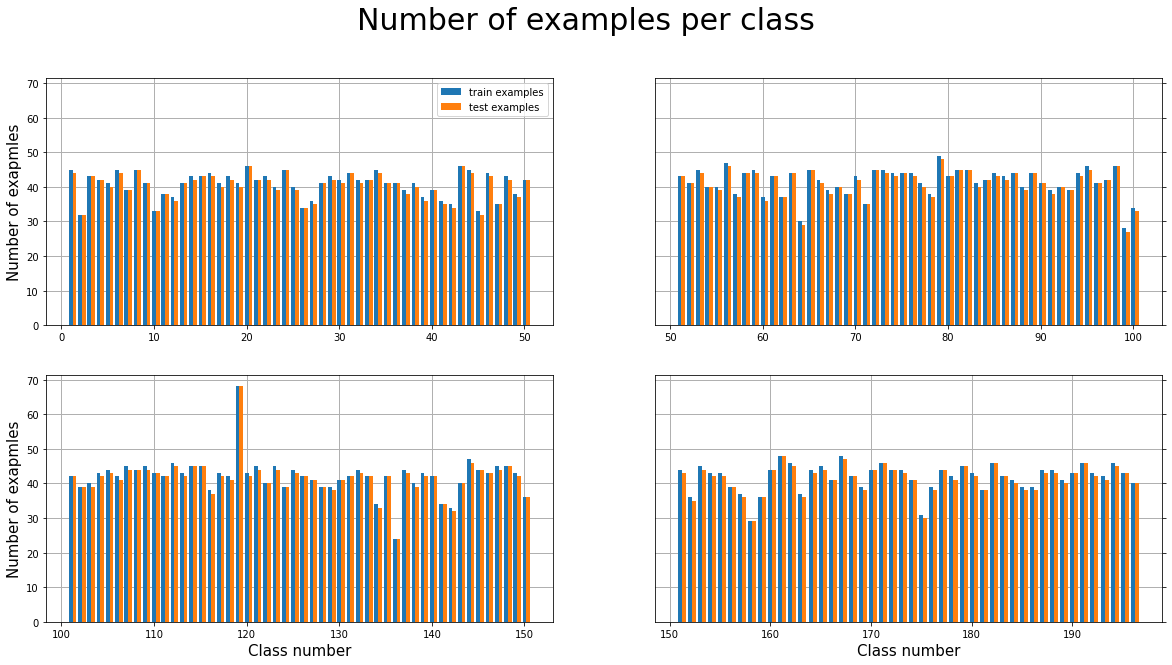

<Figure size 14.4x14.4 with 0 Axes>

In [7]:
###
#Bar chart showing number of examples per class, per dataset
###

#the class intervals covered in each of the for barcharts
interv = [0,50,100,150,len(classes_df['class_no'])+1]

# Define Data
x_ = classes_df['class_no']
x1 = x_[interv[0]:interv[1]]
x2 = x_[interv[1]:interv[2]]
x3 = x_[interv[2]:interv[3]]
x4 = x_[interv[3]:interv[4]]

r1 = np.arange(len(x1))
r2 = np.arange(len(x2))
r3 = np.arange(len(x3))
r4 = np.arange(len(x4))


y_train_ = classes_df['train_exmpl_count']
y_tr1 = y_train_[interv[0]:interv[1]]
y_tr2 = y_train_[interv[1]:interv[2]]
y_tr3 = y_train_[interv[2]:interv[3]]
y_tr4 = y_train_[interv[3]:interv[4]]

y_test_ = classes_df['test_exmpl_count']
y_tst1 = y_test_[interv[0]:interv[1]]
y_tst2 = y_test_[interv[1]:interv[2]]
y_tst3 = y_test_[interv[2]:interv[3]]
y_tst4 = y_test_[interv[3]:interv[4]]

width = 0.4

# rescale figure, and setting shared y axes
fig,axs = plt.subplots(2,2, figsize = (20,10), sharey=True)

# Draw first subplot
plt.subplot(2, 2, 1)
plt.subplot(2, 2, 1).grid(which='both', linestyle='-', linewidth='1') 
plt.subplot(2, 2, 1).set_axisbelow(True)
plt.subplot(2, 2, 1).set_ylabel('Number of exapmles',fontdict={'fontsize': 15})
plt.bar(x1, y_tr1, width=width)
plt.bar(x1 + width, y_tst1, width=width)
plt.legend(['train examples','test examples'])

# Draw second subplot

plt.subplot(2, 2, 2)
plt.subplot(2, 2, 2).yaxis.tick_right()
plt.subplot(2, 2, 2).grid(which='both', linestyle='-', linewidth='1') 
plt.subplot(2, 2, 2).set_axisbelow(True)
plt.bar(x2, y_tr2, width=width)
plt.bar(x2 + width, y_tst2, width=width)

# Draw third subplot

plt.subplot(2, 2, 3)
plt.subplot(2, 2, 3).grid(which='both', linestyle='-', linewidth='1') 
plt.subplot(2, 2, 3).set_axisbelow(True)
plt.subplot(2, 2, 3).set_ylabel('Number of exapmles',fontdict={'fontsize': 15})
plt.subplot(2, 2, 3).set_xlabel('Class number',fontdict={'fontsize': 15})
plt.bar(x3, y_tr3, width=width)
plt.bar(x3 + width, y_tst3, width=width)

# Draw forth subplot
plt.subplot(2, 2, 4)
plt.subplot(2, 2, 4).yaxis.tick_right()
plt.subplot(2, 2, 4).grid(which='both', linestyle='-', linewidth='1') 
plt.subplot(2, 2, 4).set_axisbelow(True)
plt.subplot(2, 2, 4).set_xlabel('Class number',fontdict={'fontsize': 15})
plt.bar(x4, y_tr4, width=width)
plt.bar(x4 + width, y_tst4, width=width)


#plt.yaxis.tick_right()
fig.suptitle('Number of examples per class', fontsize=30)
f = plt.figure()
f.set_figwidth(0.2)
f.set_figheight(0.2)


plt.show()

- ### Findings: </br>

    - Verified the dataset description that sais ["The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split."](https://ai.stanford.edu/~jkrause/cars/car_dataset.html)
    - Class imbalance:
        - The percentage comparison shows that there is class imbalance for at least two (136 and 119) classes. 
        - The large differences in bar heights in the visualization indicates that there are more classes than two that contribute to class imbalance in the datasets.

<a name='cons2'></a>
### Consistency check: Check for duplicate examples
- The check identifies:
    - Duplicates in the train dataset
    - Duplicates in the test dataset
    - Examples that can be in both test and train datasets
    
Note: The check is based on identifying files with the same size, and manually checking identified files. Identical images with different size cannot be identified with this check

In [8]:
###
#Identifying duplicates
###

# Helper function: prepare a df with filename and filesize, for a dataset and a class 
def name_size_df (dataset, class_):
    '''
    returns a dataframe with the file name and file size for a class, for
    the test or train datasets
    Arguments:
        dataset -> (string) defining if it is the test or train dataset
        class_ -> (int) defining the class number
    Results:
        Returns a dataframe, with two columns: 'file_name' and'file_size'] for each 
        example of the chosen class and chosen dataset
    Note:
        Meant to be used in the check_class_files() function 
    '''
    if dataset == 'train':
        path = "Data/train/"
        data = cars_train['annotations'][0]
    elif dataset == 'test':
        path = "Data/test/"
        data = cars_test_annos['annotations'][0]
    else:
        raise Exception("choose dataset = 'test' or 'train'")
    
    list = [] # a list to be filled with [filename, size] for each filename for a class
    df = pd.DataFrame(data) #making a dataframe with the annotations
    fnames_ = df['fname'].loc[df['class'] == class_] #filtering the filenames of class = class_ 
    for fname_ in fnames_:
        file_size = os.path.getsize(path+str(fname_[0]))
        list.append([fname_[0],file_size])
    df2 = pd.DataFrame(list)
    df2.columns = ['file_name','file_size']
    return df2

#Helper function:
def check_class_files(class_):
    '''
    Prints filenames with the same size between train and test datasets, for a class
    Arguments:
        class_ -> number of class to find files of the same size
    Results:
        prints the files that have the same size
    '''
    test_file_size = name_size_df ('test', class_)
    train_file_size = name_size_df ('train', class_)
    for i in range (0,len(test_file_size)): # loop through all file sizes in test_file_size df
        file_name = test_file_size['file_name'][i]
        file_size = test_file_size['file_size'][i]
        for k in range (0,len(train_file_size)): # loop through all file sizes in train_file_size df
            file_name_ = train_file_size['file_name'][k]
            file_size_ = train_file_size['file_size'][k]
            if file_size == file_size_:
                print ("in test  dataset:", file_name, 'is of size',file_size)
                print ("in train dataset:", file_name_, 'is of size', file_size_)
                print ('---')
                
###
#Identifying images with the same size, when comparing each class:
###
for i in range (1, 196):
    check_class_files(i)
    
    
##To improve: v2:- add additional check that identifies images with the same dimensions w-h. This may limit the manual labor
##            v3:- add cell that prints images  for manual checking
##            v4:- add check that identifies same pixel values for random images

in test  dataset: 05380.jpg is of size 8599
in train dataset: 00698.jpg is of size 8599
---
in test  dataset: 02026.jpg is of size 1708
in train dataset: 00097.jpg is of size 1708
---
in test  dataset: 06285.jpg is of size 12538
in train dataset: 07105.jpg is of size 12538
---
in test  dataset: 06784.jpg is of size 10867
in train dataset: 00080.jpg is of size 10867
---
in test  dataset: 05487.jpg is of size 47857
in train dataset: 00862.jpg is of size 47857
---
in test  dataset: 05773.jpg is of size 42759
in train dataset: 04986.jpg is of size 42759
---
in test  dataset: 01568.jpg is of size 12023
in train dataset: 00789.jpg is of size 12023
---


### Findings:

- Manual inspection of the identified examples revealed that one image is used in both the test and training sets:

- In the test dataset, image '05487.jpg' is the same with image '00862.jpg' in the train dataset.
- The same image is also double in the total dataset (car_ims.tar). We correct this [here](#duplicate).

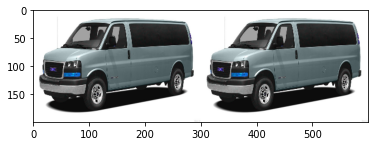

In [9]:
###
#Showing the two images site by site:
###
train_image = cv2.imread("Data/test/05487.jpg", cv2.IMREAD_ANYCOLOR)
test_image = cv2.imread("Data/train/00862.jpg", cv2.IMREAD_ANYCOLOR)

width = 300
height = 200
points = (width, height)

# resizing examples for better preview
train_image = cv2.resize(train_image, points, interpolation= cv2.INTER_LINEAR)
test_image = cv2.resize(test_image, points, interpolation= cv2.INTER_LINEAR)

# concatenate image Horizontally
Hori = np.concatenate((train_image, test_image), axis=1)

#cv2.imshow('Identical', Hori)



# call imshow() using plt object
plt.imshow(Hori)
 
# display that image
plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()

 <a name='A-3'></a>
## 3) Bounding box inspection.

In [10]:
###
#Helper functions for preparing and saving examples with bb in a folder
###

# Prepares a dataframe with columns 'fname', 'bb', 'class' for a dataset (test, train or total)
def fname_bb_class_df(dataset):
    '''
    Reads test, train or total datasets, and returns a dataframe with filename, bb coordinates, and class
    Arguments:
        dataset -> (string) can be 'train', 'test' or 'total'
    Returns:
        df -> a dataframe with columns ['fname', 'bb', 'class'], where
            'fname' -> (string) is the filename,
            'bb' -> (list) is the bounding box coordinates, in the format [x0,y0,x1,y1], and
            'class' -> (int) is the class number. This dataframe is filled for all examples in the dataset.
    '''
    if dataset == 'train':
        data = cars_train['annotations'][0]
    elif dataset == 'test':
        data = cars_test_annos['annotations'][0]
    elif dataset == 'total':
        data = cars_annos['annotations'][0]        
    else:
        raise Exception("choose dataset = 'test' , 'train' or 'total'")
    fname = []
    bb = []
    class_ = []
    if (dataset == "test") or (dataset == "train"):
        for array in data:
            fname.append(array[5][0]) 
            x0 = array[0][0][0]
            y0 = array[1][0][0]
            x1 = array[2][0][0]
            y1 = array[3][0][0]
            bb.append([x0,y0,x1,y1])
            class_.append(array[4][0][0])

    else:
        for array in data:
            fname.append(array[0][0][8:]) 
            x0 = array[1][0][0]
            y0 = array[2][0][0]
            x1 = array[3][0][0]
            y1 = array[4][0][0]
            bb.append([x0,y0,x1,y1])
            class_.append(array[5][0][0])
    
    fname_bb_list = [fname,bb,class_]
    df = pd.DataFrame (fname_bb_list).transpose()
    df.columns = ['fname', 'bb', "class"]
    return df


# Returns fname, bb  and class from a dataframe
def fname_bb_read (df,i):
    '''
    Reads the filename (as a sting), the bounding box coordinates (as an array) and the class from
    a df. It is ment to be used in a loop, in combination with the function fname_bb_class(dataset)
    Arguments:
        df -> a dataframe that has the columns ['fname', 'bb', "class"] 
        i -> number of example to read from the dataframe
    Returns:
        fname, bb, class -> filename, and bounding box coordinates and class
    '''
    fname = df['fname'][i]
    bb = df['bb'][i]
    class_ = df['class'][i]
    return fname, bb, class_

    
# Prepares an example with its bounding box:
def viz_bb(fname,dataset,bb,show = False):
    '''
    Prepares an image in the defined path, with the bounding box drawn.
    It can also display the image with the bounding box if show = 'True'
    Arguments
        fname -> (string) an image file name
        dataset -> (string) 'test' or 'train'    
        bb -> (list) [x0,y0,x1,y1] where:
            x0: Min x-value of the bounding box, in pixels
            y0: Min y-value of the bounding box, in pixels
            x1: Max x-value of the bounding box, in pixels
            y1: Max y-value of the bounding box, in pixels
        show -> (boolean) defines it the prepared image will appear in a new window or 
                 not. Default is False
    Results:
        return an img with the bb drawn
    Example: 
        viz_bb('02994.jpg','test',[0,200,0,100], True)
    '''
    if dataset == 'train':
        path = "Data/train"
    elif dataset == 'test':
        path = "Data/test"
    elif dataset == 'total':
        path = 'Data/car_ims'
    else:
        raise Exception("choose dataset = 'test' or 'train'")

    path = os.path.join(path, fname)
    
    img = cv2.imread(path, cv2.IMREAD_ANYCOLOR)
    image_copy = img.copy()
    start_point = (bb[0],bb[1]) #(x0,y0)
    end_point = (bb[2],bb[3]) #(x1,y1)
    cv2.rectangle(image_copy, start_point, end_point, (0, 0, 255), thickness= 3, lineType=cv2.LINE_8)
    
    if show:
        # display that image
        plt.imshow(image_copy)
        plt.show()
        cv2.imshow('BoundingBox', image_copy)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    return image_copy
    
# Writes the image in a folder
def image_to_folder(img,fname, dataset):
    '''
    Takes an image, and writes it in a newly created folder. Folder can be 
    either for train ("Data/train_bb") or test ("Data/test_bb)"sets, and 
    it is defined by the "dataset" 
    Arguments:
        img -> an image, ment to take the output from the viz_bb() function
        fname -> (string) the image file name
        dataset -> (string) 'test' or 'train'
    Results:
        Writes the img to a new folder ("Data/train_bb" or "Data/test_bb")
        Does not return anything.    
    '''
    if dataset == 'train':
        new_path = "Data/train_bb"
        old_path = "Data/train"
    elif dataset == 'test':
        new_path = 'Data/test_bb' 
        old_path = "Data/test"
    else:
        raise Exception("choose dataset = 'test' or 'train'")

    if not os.path.exists(new_path):
        os.makedirs(new_path)

    path = os.path.join(old_path, fname)
    image_copy = img.copy()
    new_path = os.path.join(new_path, fname)
    cv2.imwrite(new_path,image_copy)

# Creates a folder of images with their bounding boxes
def bb_examples(dataset):
    '''
    Draws bounding boxes around the examples and saves them in a folder, for test or train datasets.
    Arguments
        dataset -> (string) "test or train"
    Results
        Creates a folder, train_bb or test_bb, with images of the examples and their bounding boxes
    '''
    df = fname_bb_class_df(dataset) # Creates a df with all the examples in the dataset
    for i in range (0, len(df)): # loops through the df 
        fname, bb, _ = fname_bb_read (df,i) # takes the fname and bb of an example
        img = viz_bb(fname,dataset,bb) # prepares the image with the bb
        image_to_folder(img,fname, dataset) # writes it to the apropriate folder

In [11]:
###
# Create folder with examples and bb's drawn on hard disk, if option is selected in the beginning.
###

if SAVE_BB_IMG == 'Y':
    ###
    #preparing all examples with their bounding box, in folder Data/train_bb
    ###
    dataset = 'train'
    bb_examples(dataset)

    ###
    #preparing all examples with their bounding box, in folder Data/test_bb
    ###
    dataset = 'test'
    bb_examples(dataset)

### Findings:
- Bounding boxes are around cars as expected. Very few examples have larger bbs than the cars.
- Each bounding box has a full car inside. Very few (~2-3%) of the examples have only part of the car in the image (and thus in the bb)

<font size =2>Note: A preprocessing step that modifies existing examples (by e.g. cropping / rotating / resizing existing images) will allow for a neural network to train in (and identify) images with parts of a car. <font>

<a name='A-4'></a>
# 4) Data modifications: Correcting identified errors

- In this part, we correct:</br>
    - The rotated image</br>
    - The duplicate image</br>

### Correcting the rotated image: <a name='rotated'></a>

Previously we identified an example in the train dataset that was rotated. This example was filename 07389.jpg. The way we corrected this was manually rotating the image, saving it and replacing the old rotated one. For verifying the error and the correction the following cell was used:

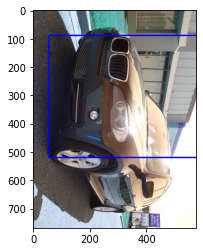

In [12]:
#Preview of the identified rotated image, and the bounding box: 
dataset = "train"
fname = "07389.jpg"
df = fname_bb_class_df(dataset) # create the dataframe with filename and bounding box for train
i = int(df.loc[df['fname'] == fname].index[0]) #search dataframe index for specific example:
# print (df.iloc[i]) # veryfy that we chose the correct image:
fname, bb, _ = fname_bb_read (df,i)
_ = viz_bb(fname,dataset,bb,show = True)

##Note:
# Running this cell on the original dataset shows the rotated image, and the bounding box for this example. 
# The bounding box refers to the non-rotated image.

# The image was manually rotated and saved to replace the original [both in the train folder, as well as in 
#the cars_ims folder]. 

#After rotating 270degrees clockwise, the image is corrected, and the bounding box is correct. This was 
#verified by running again this cell, after the correction.

### Duplicated images:  <a name='duplicate'></a>

- During consistency checks we found that there is one duplicated file in the dataset.
    This file is:
        - image '05487.jpg' in the test dataset (Data/test/)
        - image '00862.jpg' in the train dataset (Data/train/)
        - images 09723.jpg and 010077.jpg in the total dataset (Data/cars_ims/)
 
- To address this, we :
    - 1) Deleted one of the two images.
    - 2) Made data consistent with the changes


#### 1) Deleting one of the two images:

- Manually deleted image '00862.jpg' in the train dataset (Data/train/) and image 010077.jpg in the Data/cars_ims/ folder.


#### 2) Make data consistent with the changes:

##### - In file naming:
- Manually modified image names in the two edited folders, so that there is consistency with the increasing number naming. For this reason, the last image in the appropriate dataset was renamed to have the same name as the deleted.
    - in the train folder, image '08144.jpg' became image '00862.jpg'
    - in the cars_ims folder, image '016185.jpg' became '010077.jpg' </br> </br>
      Note 1: the examples in the cars_ims folder are named in an increasing order according to their class. Although the duplicate correction that was made changed that, it will not affect the final training of the neural network. </br>
      
##### - In fname, bounding boxes and annotated classes recorded in the dataframes

In [13]:
#Helper function that replaces the values of the file a, with those of file b in a dataframe 
def replace_bb_class(df,a_fname,b_fname):
    '''
    For a dataframe (df),the function replaces the bounding box value and class value of the a_fname file, 
    with those of the b_fname file and deletes the last row of the df (which happens to be the B_fnamefile).
    It is ment to be used after specific manual corrections for duplicated images found in the dataset.
    Arguments:
        df -> a dataframe with columns: ['fname', 'bb', 'class']
        a_fname -> name of the deleted file, the duplicate
        b_fname -> name of the file that replaced the duplicate
    Results:
        Returns an updated version of the df.
    '''
    #finding the indexes of files a and b:
    i_a = int(df.loc[df['fname'] == a_fname].index[0])
    i_b = int(df.loc[df['fname'] == b_fname].index[0])

    # Identifying the bb and class of file B:
    df.at[i_a, 'bb'] = df.at[i_b, 'bb']
    df.at[i_a, 'class'] = df.at[i_b, 'class']

    #"delete" the last row
    df = df.head(-1)
    
    return df

# Creat dataframes with the fname, bb and class for the original dataframes
for dataset in ['test', 'train', 'total']:
    locals()[dataset+"_df"] = fname_bb_class_df(dataset)
    #Dataframes will be named: test_df, train_df and total_df accordingly
    
#defining the affected images    
a_train_fname = '00862.jpg' # filename that was deleted and replaced
a_total_fname = '010077.jpg' # filename that was deleted and replaced
b_train_fname = "08144.jpg" # filename that replaced the duplicate
b_total_fname = "016185.jpg" # filename that replaced the duplicate


#updating the dataframes: {correcting the bb and class of the replaced images and deleting the last rows in the dataframe}
train_df = replace_bb_class(train_df,a_train_fname,b_train_fname)    
total_df = replace_bb_class(total_df,a_total_fname,b_total_fname)

- ### Conclusions of part A:</br>

    - The data distribution includes well-framed cars and a single car in each image. Each class has an average of 41 examples. This number is very low to achieve a good performance.
    - There is a Class imbalance issue for few classes.
    - Some errors with images (duplicates and rotated image) were corrected.

<a name='B'></a>
# Part B: Preparing the new dataset

- 1) Define new classes.
- 2) Convert data from old classes (car model) to new classes (car brand)
- 3) Explore new data created (analyze the examples per class, identify if there is class imbalance)
- 4) Re-separate examples randomly (if train/test come from the same data distribution) to 80%/20%
- 5) Prepare the data to be read by Yolo v5

<a name='B-1'></a>
## 1) Define new classes:

The car type (Sedan, Hatchback, Convertible, SUV..) is included in the original class description for each example:
"Volkswagen Beetle **Hatchback** 2012" , "Acura TL **Sedan** 2012". The next steps isolate the car type and define a new class.

In [14]:
###
#Identifies the car types listed in the dataset (in classes_df) according to the original class description:
###

#Isolates the word before the year in class description
new_class_descr = []
for car in classes_df['class_descr']:
    car_type = car[slice(0,-5,1)] #slicing out the last 5 digits - the year from the name
    i = car_type.rindex(' ') #finding the index of the last space used in the string, before car type
    car_type = car_type[slice(i+1,len(car_type),1)]  #slicing only the car type
    new_class_descr.append(car_type)

    
#Updates the existing dataframe with the new class
new_class_list = list(set(new_class_descr))
classes_df['new_class_descr'] = new_class_descr


#creates a new dataframe with the new class number and the new class description
new_class_df = (pd.DataFrame(new_class_list))
new_class_df.reset_index(inplace=True)
new_class_df['index'] = new_class_df['index']+1 
new_class_df.columns = ['new_class_no', 'new_class_descr']
new_class_df

,new_class_no,new_class_descr
0,1,XKR
1,2,Minivan
2,3,R
3,4,Abarth
4,5,ZR1
5,6,Hatchback
6,7,IPL
7,8,SS
8,9,Van
9,10,SRT-8


In [15]:
###
#Finding the number of examples for the new classes:
###

# making a dictionary for new classes: {new_class_no: new_class_descr}
new_class_dict = pd.Series(new_class_df.new_class_descr.values,index=new_class_df.new_class_no).to_dict()

# making a dictionary for new class descr: {cnew_class_descr: new_class_no}
new_class_rev_dict = {v: k for k, v in new_class_dict.items()}

# making a dictionary for old classes: {class_no: class_descr}
old_class_dict = pd.Series(classes_df.class_descr.values,index=classes_df.class_no).to_dict()


# Identifies the new_class_no for each of the new_class_descr and updates the class_df
new_class_numbs = [new_class_rev_dict[new_class] for new_class in classes_df['new_class_descr']]
classes_df['new_class_no'] = new_class_numbs


# Counts no of examples for the new classes
new_class_count = pd.DataFrame(classes_df.groupby(['new_class_descr'])['total_exmpl_count'].sum())#.reset_index(inplace=True)
new_class_count.reset_index(inplace=True)

new_class_count

,new_class_descr,total_exmpl_count
0,Abarth,55
1,Cab,1430
2,Convertible,2058
3,Coupe,2096
4,GS,70
5,Hatchback,1103
6,IPL,68
7,Minivan,498
8,R,89
9,SRT-8,181


In [16]:
###
#Choose classes with number of examples > 450 (which is also the car type)
###
car_type_df = new_class_count.loc[new_class_count.total_exmpl_count > 450]
car_type_df.reset_index(inplace = True, drop = True)
car_type_df = car_type_df.copy(deep=True)
car_type_df

,new_class_descr,total_exmpl_count
0,Cab,1430
1,Convertible,2058
2,Coupe,2096
3,Hatchback,1103
4,Minivan,498
5,SUV,2855
6,Sedan,3787
7,Van,578
8,Wagon,503


In [17]:
###
#Analyze excluded new_classes for further insides:
###

#Identifies excluded new_classes:
excl = new_class_count.loc[new_class_count.total_exmpl_count <= 450]
excl.reset_index(inplace=True)

#Identifies excluded new_classes with more than a single car model:
for i in range (0, len(excl)):
    test = classes_df.loc[classes_df["new_class_descr"] == list(excl['new_class_descr'])[i]]
    if len(test) >1:
        print ('--------')
        print (i)
        print ('Car "type":',excl['new_class_descr'][i])
        print (test.loc[:,['class_no','class_descr','total_exmpl_count']])
        


--------
4
Car "type": SRT-8
    class_no               class_descr  total_exmpl_count
78        79   Chrysler 300 SRT-8 2010                 97
96        97  Dodge Charger SRT-8 2009                 84
--------
6
Car "type": SS
    class_no                    class_descr  total_exmpl_count
59        60          Chevrolet HHR SS 2010                 73
65        66       Chevrolet Cobalt SS 2010                 83
67        68  Chevrolet TrailBlazer SS 2009                 80


### Each excluded class:
   - does not describe the car type, but rather a car model.
   - comes from one car maker, or other characteristic of the car (e.g. SRT-8: engine by "Street Race Technology" with 8 cylinders).
   - as a result, the count for these is very small compared to the rest that describe a car type.

In [18]:
###
# Filter the examples of the chosen classes
###

# Make a copy of the (old) dataframe with all examples with the car models, from cars_ims folder.
examples_df = total_df.copy(deep=True)
examples_df

##
# Add the new class to the df for each example:
##

#dictionary from old class to new:
old_to_new_classno_dict = pd.Series(classes_df.new_class_no.values,index=classes_df.class_no).to_dict()

#add new_class_no to the df per example:
new_class_no = [old_to_new_classno_dict[class_no] for class_no in examples_df['class']]
examples_df['new_class'] = new_class_no
examples_df

#add class_descr and new_class_descr to the examples_df
class_descr = [old_class_dict[class_no] for class_no in examples_df['class']]
new_class_descr = [new_class_dict[class_no] for class_no in examples_df['new_class']]
examples_df['class_descr'] = class_descr
examples_df['new_class_descr'] = new_class_descr

#filter only chosen classes with no of exmpls > 450
new_exmpls_df = examples_df.loc[examples_df["new_class_descr"].isin(car_type_df['new_class_descr'])]
new_exmpls_df.reset_index(inplace = True, drop = True)

#Check number of examples: 
if len(examples_df) != len(new_exmpls_df) + excl['total_exmpl_count'].sum():
    raise Exception('Some examples disappeared... Check: "examples_df", "new_exmpls_df" and "excl" for consistency')
    
new_exmpls_df

,fname,bb,class,new_class,class_descr,new_class_descr
0,000001.jpg,"[112, 7, 853, 717]",1,22,AM General Hummer SUV 2000,SUV
1,000002.jpg,"[48, 24, 441, 202]",1,22,AM General Hummer SUV 2000,SUV
2,000003.jpg,"[7, 4, 277, 180]",1,22,AM General Hummer SUV 2000,SUV
3,000004.jpg,"[33, 50, 197, 150]",1,22,AM General Hummer SUV 2000,SUV
4,000005.jpg,"[5, 8, 83, 58]",1,22,AM General Hummer SUV 2000,SUV
...,...,...,...,...,...,...
14902,016180.jpg,"[56, 64, 474, 323]",196,14,smart fortwo Convertible 2012,Convertible
14903,016181.jpg,"[38, 36, 375, 234]",196,14,smart fortwo Convertible 2012,Convertible
14904,016182.jpg,"[29, 34, 235, 164]",196,14,smart fortwo Convertible 2012,Convertible
14905,016183.jpg,"[25, 32, 587, 359]",196,14,smart fortwo Convertible 2012,Convertible


In [19]:
###
#Redifine the class number
###
car_type_df.reset_index(inplace= True)
car_type_df.rename(columns = {'index':'class'}, inplace = True)
car_type_df["class"]=car_type_df["class"]+1
car_type_df

,class,new_class_descr,total_exmpl_count
0,1,Cab,1430
1,2,Convertible,2058
2,3,Coupe,2096
3,4,Hatchback,1103
4,5,Minivan,498
5,6,SUV,2855
6,7,Sedan,3787
7,8,Van,578
8,9,Wagon,503


In [20]:
#dictionary from new_class_descr to redifined class:
final_classno_dict = pd.Series(car_type_df['class'].values,index=car_type_df.new_class_descr).to_dict()

# Make a dataframe for new selected examples
new_class = [final_classno_dict[new_class_descr] for new_class_descr in new_exmpls_df['new_class_descr']]
new_exmpls_df['new_class'] = new_class
new_exmpls_df

C:\Users\Savvas\AppData\Local\Temp/ipykernel_4860/4135262787.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_exmpls_df['new_class'] = new_class


,fname,bb,class,new_class,class_descr,new_class_descr
0,000001.jpg,"[112, 7, 853, 717]",1,6,AM General Hummer SUV 2000,SUV
1,000002.jpg,"[48, 24, 441, 202]",1,6,AM General Hummer SUV 2000,SUV
2,000003.jpg,"[7, 4, 277, 180]",1,6,AM General Hummer SUV 2000,SUV
3,000004.jpg,"[33, 50, 197, 150]",1,6,AM General Hummer SUV 2000,SUV
4,000005.jpg,"[5, 8, 83, 58]",1,6,AM General Hummer SUV 2000,SUV
...,...,...,...,...,...,...
14902,016180.jpg,"[56, 64, 474, 323]",196,2,smart fortwo Convertible 2012,Convertible
14903,016181.jpg,"[38, 36, 375, 234]",196,2,smart fortwo Convertible 2012,Convertible
14904,016182.jpg,"[29, 34, 235, 164]",196,2,smart fortwo Convertible 2012,Convertible
14905,016183.jpg,"[25, 32, 587, 359]",196,2,smart fortwo Convertible 2012,Convertible


In [21]:
#  Dataframes prepared with the new class:
#   - car_type_df: ['class','new_class_descr','total_exmpl_count']
#   - new_exmpls_df: [fname','bb','class','new_class','class_descr','new_class_descr']

In [22]:
new_exmpls_df

,fname,bb,class,new_class,class_descr,new_class_descr
0,000001.jpg,"[112, 7, 853, 717]",1,6,AM General Hummer SUV 2000,SUV
1,000002.jpg,"[48, 24, 441, 202]",1,6,AM General Hummer SUV 2000,SUV
2,000003.jpg,"[7, 4, 277, 180]",1,6,AM General Hummer SUV 2000,SUV
3,000004.jpg,"[33, 50, 197, 150]",1,6,AM General Hummer SUV 2000,SUV
4,000005.jpg,"[5, 8, 83, 58]",1,6,AM General Hummer SUV 2000,SUV
...,...,...,...,...,...,...
14902,016180.jpg,"[56, 64, 474, 323]",196,2,smart fortwo Convertible 2012,Convertible
14903,016181.jpg,"[38, 36, 375, 234]",196,2,smart fortwo Convertible 2012,Convertible
14904,016182.jpg,"[29, 34, 235, 164]",196,2,smart fortwo Convertible 2012,Convertible
14905,016183.jpg,"[25, 32, 587, 359]",196,2,smart fortwo Convertible 2012,Convertible


In [23]:
car_type_df

,class,new_class_descr,total_exmpl_count
0,1,Cab,1430
1,2,Convertible,2058
2,3,Coupe,2096
3,4,Hatchback,1103
4,5,Minivan,498
5,6,SUV,2855
6,7,Sedan,3787
7,8,Van,578
8,9,Wagon,503


### Summary

    - New classes were defined that describe the car_type.
    - Some original classes did not include the car type in their name and were excluded.
    - Each new class has more than 450 examples.

<a name='B-2'></a>
## 2) Re-separate examples and prepare the dataset for Yolo v5.

In [24]:
####
#Create the folders needed for YoloV5
####

#Verify or create the following folders_structure:
'''
data
├── data.yaml
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels
'''
###
folder1 = 'YOLO_v5_Data' #parent directory of the created data
folder2 = 'data'
train_dir = os.path.join(folder1, folder2,'train')
valid_dir = os.path.join(folder1, folder2,'valid')
train_images_dir = os.path.join(train_dir,'images')
valid_images_dir = os.path.join(valid_dir,'images')
train_labels_dir = os.path.join(train_dir,'labels')
valid_labels_dir = os.path.join(valid_dir,'labels')


for folder in (train_images_dir, valid_images_dir,train_labels_dir,valid_labels_dir):
    try:
        os.makedirs(folder)
     # unsafe operation perform
        print(folder, "created")
        
    except FileExistsError:
        print("Folder", folder, "exist")

YOLO_v5_Data\data\train\images created
YOLO_v5_Data\data\valid\images created
YOLO_v5_Data\data\train\labels created
YOLO_v5_Data\data\valid\labels created


In [25]:
###
# Randomly choose the same number of examples per class to create a new balanced class df, and separate to train /valid. 
###

def class_train_test_split(class_, n):
    '''
    Argumets:
        class_ -> number of class (refered to new class)
        n -> no of examples per class
    Returns:
        train_indexes, valid_indexes -> two lists with indexes (refered to the 'new_exmpls_df' dataframe) for
        the examples in the train and valid datasets
    '''
    random.seed(SEED) # make sure the "random" choice is repeatable, and always creates the same dataset
    train_percent = train_prc
    # filter by class
    class_fnames = new_exmpls_df.loc[new_exmpls_df.new_class == class_]

    # make a list with those indexes:
    index_list = list(class_fnames.index)
    #choose random n indexes from the list of indexes for the new balanced dataset:
    n_indexes = random.sample(index_list, n)


    #choose random train_percent indexes for the train dataset and what is left (outer join?) for the test dataset
    train_count = int(n * 80 / 100)
    train_indexes = random.sample(n_indexes, train_count)

    valid_indexes = set(n_indexes).symmetric_difference(set(train_indexes))
    valid_indexes = list(valid_indexes)
    
    return train_indexes, valid_indexes



df = new_exmpls_df 
n = 498 #choose number of examples per class

train_percent = train_prc #choose percentage of samples for the train dataset
classes_number = len(set(new_exmpls_df['new_class']))


# find indexes for train/valid datasets
train_indexes = []
valid_indexes = []
for class_ in range (1,classes_number+1):
    train_index, valid_index = class_train_test_split(class_,n)
    train_indexes.extend(train_index)
    valid_indexes.extend(valid_index)
    
# find fnames for train/valid datasets
train_fnames = []
valid_fnames = []  
for i in train_indexes:
    train_fname = new_exmpls_df['fname'].loc[i]
    train_fnames.append(train_fname)
for i in valid_indexes:
    valid_fname = new_exmpls_df['fname'].loc[i]
    valid_fnames.append(valid_fname)

In [26]:
###
#Checking for imbalance towards specific car models (in train dataset):
###
train_indexes = train_indexes
valid_indexes = valid_indexes


train_examples_df = new_exmpls_df.loc[train_indexes].copy(deep=True)
valid_examples_df = new_exmpls_df.loc[valid_indexes].copy(deep=True)
valid_exmpls_breakdown = pd.DataFrame(valid_examples_df.groupby(['new_class','class'])['class_descr'].size()).reset_index()
valid_exmpls_breakdown = valid_exmpls_breakdown.rename(columns = {'class_descr':'count'})
train_exmpls_breakdown = pd.DataFrame(train_examples_df.groupby(['new_class','class'])['class_descr'].size()).reset_index()
train_exmpls_breakdown = train_exmpls_breakdown.rename(columns = {'class_descr':'count'})

car_model_imb = pd.DataFrame({"new_class":[],"Car_models":[],"examples_count":[]})
car_model_imb.columns 

for i in range (1,10): #loop through all classes
    class_no = i
    no_of_car_models = len(train_exmpls_breakdown.loc[train_exmpls_breakdown['new_class'] == class_no])
    no_of_examples = train_exmpls_breakdown['count'].loc[train_exmpls_breakdown['new_class'] == class_no].sum()
    car_model_imb.loc[len(car_model_imb)] = [i, no_of_car_models, no_of_examples]    
display(car_model_imb)

,new_class,Car_models,examples_count
0,1,17,398
1,2,26,398
2,3,25,398
3,4,13,398
4,5,6,398
5,6,34,398
6,7,46,398
7,8,7,398
8,9,6,398


### Car model imbalance

- The newly created dataset has no class imbalance issues, as we chose the same number of examples for each class.
- However, there is an imbalance in specific car models/makers per car type.

In [27]:
###
#copy images to train and valid folder
###
def copy_image(fname):
    if fname in train_fnames:
        destination = 'YOLO_v5_Data\\data\\train\\images'
    elif fname in valid_fnames:
        destination = 'YOLO_v5_Data\\data\\valid\\images'
    image_root = 'Data\car_ims'
    #fname = '000001.jpg'
    source = os.path.join(image_root , fname)
    shutil.copy(source, destination)

In [28]:
###
# Write txt file for each example
###

def fname_bb(fname, df = new_exmpls_df):
    '''
    Returns the bounding box coordinates for an example.
    Units in pixels
    '''
    bb = df["bb"].loc[df['fname'] == fname]
    bb = list(bb)
    bb = bb[0]
    return bb

    
def fname_to_meta(fname, df = new_exmpls_df):
    '''
    Takes as input a filename, and returns a string "class Xc Yc bb_width bb_height",
    needed for YOLO (normalized values)
    It is ment to be used to transform: (Xmin, Xmax, Ymin, Ymax) in (Xcent,Ycent,bb_width,bb_height),
    from pixel values to percentage values
    Arguments:
        fname -> (string) The filename of the image
        df -> a dataframe that includes fname, bb, and class
    '''
    bb = fname_bb(fname)    
    path = "Data/car_ims/"
    img = cv2.imread(path+fname)
    h, w = img.shape[:2]
    ########## #convet bb to Xc and YC
    Xc = str(( (int(bb[0]) + int(bb[2])) /2 ) /w)
    
    Yc = ( (int(bb[1]) + int(bb[3])) /2 ) /h
    ########## #convert real_widt and real height to width, height (to percentages)
    
    bb_width =  (bb[2]-bb[0]) / w
    bb_height = (bb[3]-bb[1]) / h
    
    fname_class = int(df["new_class"].loc[df['fname'] == fname])-1 #Class labels in yolo V5 start from 0).


    meta = str(int(fname_class)) + " " + str(Xc) +' '+ str(Yc) +' '+ str(bb_width) +' '+ str(bb_height)
    return meta

def make_folders():
    '''
    Verify or Create the following folder_structure. Return the paths created
    Arguments:
       None
    Returns:
        strings for the paths created:
        -> train_images_dir, valid_images_dir, train_labels_dir, valid_labels_dir

    data
    |
    ├── train
    │   ├── images
    │   └── labels
    └── valid
        ├── images
        └── labels
    '''
    ###
    folder1 = 'YOLO_v5_Data' #parent directory of the created data
    folder2 = 'data'
    train_dir = os.path.join(folder1, folder2,'train')
    valid_dir = os.path.join(folder1, folder2,'valid')
    train_images_dir = os.path.join(train_dir,'images')
    valid_images_dir = os.path.join(valid_dir,'images')
    train_labels_dir = os.path.join(train_dir,'labels')
    valid_labels_dir = os.path.join(valid_dir,'labels')
    
    for folder in (train_images_dir, valid_images_dir,train_labels_dir,valid_labels_dir):
        try:
            os.makedirs(folder)
         # unsafe operation perform
            print(folder, "created")

        except FileExistsError:
            print("Folder", folder, "exist")
    
    return train_images_dir, valid_images_dir, train_labels_dir, valid_labels_dir




def meta_to_txt(fname, path = 'YOLO_v5_Data\data'):

    '''
    Writes the meta string to a txt file, named as the fname.txt
    Arguments:
        fname -> (string) filename of the training example
        path -> (string) path of the 'data' folder for yolo
    Result:
        Creates a txt file for the image provided
        Does not return anything 
    '''
    if fname in train_fnames:
        destination = 'YOLO_v5_Data\\data\\train\\labels'
    elif fname in valid_fnames:
        destination = 'YOLO_v5_Data\\data\\valid\\labels'
    meta = fname_to_meta(fname)
    fnumber = fname[0:-4]  #strip .jpg from fname
    txt_fname = fnumber + '.txt' #filenme of text to be created
    txt_path = os.path.join(destination, txt_fname)
    if not os.path.exists(txt_path):
        #create the path
        f = open(txt_path, "w")
        f.write(meta)
        f.close()
    else:
        print ('File',txt_fname,'already exists, and should have',meta)

In [29]:
###
#Write examples and txt files to folders
###

#Write exampless to YOLO_v5_Data\\data\\train\\images and YOLO_v5_Data\\data\\valid\images

if prepare_test_valid:
#copy images in train/valid folders
    for list_ in [train_fnames,valid_fnames]:
        for fname in list_:
            copy_image(fname)
            
#Write text files to YOLO_v5_Data\\train\\labels and YOLO_v5_Data\\data\\valid\\labels          
if write_txt_files:
    #prepare text files for samples:
    for list_ in [train_fnames,valid_fnames]:
        for fname in list_:
            meta_to_txt(fname)

In [30]:
###
#Prepare yaml text:
###


str_yaml = """
# Path relative to the script:
path: 'YOLO_v5_Data/data'

#training images:
train: images/train

#validation images:
val: images/val

#number of classes:
nc: 9

#names of classes:
names: ['Cab',  'Convertible', 'Coupe', 'Hatchback', 'Minivan', 'SUV', 'Sedan', 'Van','Wagon']
"""
data = yaml.safe_load(str_yaml)
with open('YOLO_v5_Data/data/data.yaml', 'w') as file:
    yaml.dump(data, file)
print(open('YOLO_v5_Data/data/data.yaml').read())


names:
- Cab
- Convertible
- Coupe
- Hatchback
- Minivan
- SUV
- Sedan
- Van
- Wagon
nc: 9
path: YOLO_v5_Data/data
train: images/train
val: images/val



In [91]:
####################################################################
###################### Improvements that could be made #############
####################################################################
####################################################################

# 0) Make the notebook a 1-click-run-all
#    - Automkate downloading dataset / unzipping to correct folders
#    - Automate corrections of the errors on the images identified 
#    - (and in a later version autodetect these errors)

  
# 1) Re-define functions that create dataframes, by using pd.DataFrame. i.e.:pd.DataFrame(cars_train['annotations'][0])
#    to avoid loops


# 2) Add the possibility to add deviation in the number of examples per class. 


# 3) Add few (~10%) examples that do not have a class to reduce false positives

####################################################################
####################################################################
####################################################################